# Neural Network

In [88]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 500)


## User Parameters

In [89]:
# Define dataset path
dataset_path = "data/final_data.csv" # Filepath to dataset

# Model Parameters
use_model = False # Set to True if you want to load a model
model_path = "" # Filepath to model, if you want to load a model
n_hidden = 3 # Number of hidden layers
h_nodes = 24 # Number of nodes in the hidden layer

# Define training parameters
train = True # Set to False if you want to load a model and not train
n_epochs = 1000 # Number of epochs
batch_size = 10 # Batch size for training
loss_fn = nn.BCELoss()  # Loss function (binary cross entropy)
lr = 0.001 # Learning rate
early_stop = 3 # Number of consecutive epochs of no improvement on validation set to stop training
test_size = 0.2 # Percentage of data to use for testing, half will be used for validation

# Define if you want to use CPU or GPU
use_cpu = False


In [90]:
# Check if GPU is available and set device
gpu_available = torch.cuda.is_available()
if gpu_available and not use_cpu:
	device = torch.device("cuda:0")
	print(f"GPU Support Enabled, Using: {torch.cuda.get_device_name(0)}")  # Prints the name of the GPU
else:
	device = torch.device("cpu")
	print("No GPU available, using CPU")

GPU Support Enabled, Using: NVIDIA GeForce RTX 2070 SUPER


In [91]:
df = pd.read_csv(dataset_path)
df.head()

,status,orbital_period,transit_duration,equilibrium_temperature,stellar_effective_temperature,planet_radius_log,stellar_pca1,stellar_pca2
0,1,-0.417538,-0.573450,1.018689,-0.257530,-0.627013,-0.284366,0.667557
1,1,-0.403847,-0.406939,0.756108,0.793534,0.676241,0.318626,0.998412
2,1,-0.391812,-0.201736,0.519226,-0.337820,-0.585880,0.584852,0.866250
3,1,-0.408157,-0.600436,-0.064041,0.501572,-0.245730,0.190999,0.986024
4,1,-0.416796,-0.786621,0.406371,-1.730724,-0.272231,-0.854579,0.083679


## Split the data (Train/Test)

In [92]:
# Split into train and test
train_df, test_df = train_test_split(df, test_size=test_size)
test_df, val_df = train_test_split(test_df, test_size=0.5)

In [93]:
def prep_data(data):
	x = train_df.drop('status', axis=1)
	y = train_df['status']

	# Convert to numpy arrays
	x = np.array(x, dtype=np.float32)
	y = np.array(y, dtype=np.float32).reshape(-1,1)

	# Convert to tensors
	X = torch.tensor(x, dtype=torch.float32)
	Y = torch.tensor(y, dtype=torch.float32)

	return X, Y

In [94]:
# Prep data
X_train, Y_train = prep_data(train_df)
X_test, Y_test = prep_data(test_df)
X_val, Y_val = prep_data(val_df)

print(f"Input dimensions: {X_train.shape[1]}")
print(f"Output dimensions: {Y_train.shape[1]}")

Input dimensions: 7
Output dimensions: 1


In [95]:
# Creating/Loading the model
if use_model:
    model = torch.load(model_path)
else:
    model = nn.Sequential()
    model.add_module("input", nn.Linear(X_train.shape[1], h_nodes))
    model.add_module("relu_1", nn.ReLU())
    for h in range(0, n_hidden):
        model.add_module(f"hidden_{h+1}", nn.Linear(h_nodes, h_nodes))
        model.add_module(f"relu_{h+2}", nn.ReLU())
        model.add_module(f"dropout_{h+1}", nn.Dropout(p=0.1))
    model.add_module("output", nn.Linear(h_nodes, Y_train.shape[1]))
    model.add_module("sigmoid", nn.Sigmoid())
print(model)

Sequential(
  (input): Linear(in_features=7, out_features=24, bias=True)
  (relu_1): ReLU()
  (hidden_1): Linear(in_features=24, out_features=24, bias=True)
  (relu_2): ReLU()
  (dropout_1): Dropout(p=0.1, inplace=False)
  (hidden_2): Linear(in_features=24, out_features=24, bias=True)
  (relu_3): ReLU()
  (dropout_2): Dropout(p=0.1, inplace=False)
  (hidden_3): Linear(in_features=24, out_features=24, bias=True)
  (relu_4): ReLU()
  (dropout_3): Dropout(p=0.1, inplace=False)
  (output): Linear(in_features=24, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [96]:
# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

In [97]:
# Transfer model to GPU if available
if gpu_available and not use_cpu:
	print(f"Transferring model to GPU: {torch.cuda.get_device_name(0)}")
	model = model.cuda()
	loss_fn = loss_fn.cuda()

	# Transfer validation data to GPU
	X_val = X_val.cuda()
	Y_val = Y_val.cuda()

Transferring model to GPU: NVIDIA GeForce RTX 2070 SUPER


## Training
Now that the data and the network is set up, lets train the model! After training the model will be saved to a file so that you don't have to train it again if you want to use it for predictions in the future.

In [98]:
def accuracy(Y_pred, Y):
	Y_pred = torch.round(Y_pred)
	return (Y_pred == Y).sum().float() / len(Y_pred)

In [99]:
# Train the model
losses = []
v_losses = []
if train:
    for epoch in range(n_epochs):
        for i in range(0, len(X_train), batch_size):
            # Get batch
            X_batch = X_train[i:i+batch_size]
            Y_batch = Y_train[i:i+batch_size]

            # Transfer to GPU if available
            if gpu_available and not use_cpu:
                X_batch = X_batch.cuda()
                Y_batch = Y_batch.cuda()

            # Feedforward
            Y_pred = model(X_batch)

            # Calculate loss
            loss = loss_fn(Y_pred, Y_batch)

            # Backpropagate error and update weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Check validation loss
        Y_pred = model(X_val)
        with torch.no_grad():
            val_loss = loss_fn(Y_pred, Y_val)

            # Save loss
            losses = losses + [loss.item()]
            v_losses = v_losses + [val_loss.item()]

        # Early stopping
        if len(v_losses) >= early_stop+1:
            # Check if validation loss hasn't improved for 'early_stop' epochs
            for i in range(early_stop):
                if v_losses[-1-i] >= v_losses[-2-i]:
                    print(f"Early stopping at epoch {epoch}")
                    break

        # Print loss after each epoch
        print(f'Finished epoch {epoch}, latest loss {loss} val_loss {val_loss}')


Finished epoch 0, latest loss 0.3971518278121948 val_loss 0.324266254901886
Finished epoch 1, latest loss 0.17271029949188232 val_loss 0.28063246607780457
Finished epoch 2, latest loss 0.16430523991584778 val_loss 0.2642916440963745
Finished epoch 3, latest loss 0.12656475603580475 val_loss 0.2564927041530609
Finished epoch 4, latest loss 0.1827518194913864 val_loss 0.24964363873004913
Finished epoch 5, latest loss 0.13667768239974976 val_loss 0.24680548906326294
Finished epoch 6, latest loss 0.12595000863075256 val_loss 0.24623878300189972
Finished epoch 7, latest loss 0.09833112359046936 val_loss 0.24066054821014404
Finished epoch 8, latest loss 0.11409105360507965 val_loss 0.24140800535678864
Finished epoch 9, latest loss 0.08527680486440659 val_loss 0.23850364983081818
Finished epoch 10, latest loss 0.12233766913414001 val_loss 0.2379566878080368
Finished epoch 11, latest loss 0.09279084205627441 val_loss 0.23564697802066803
Finished epoch 12, latest loss 0.08136139810085297 val_lo

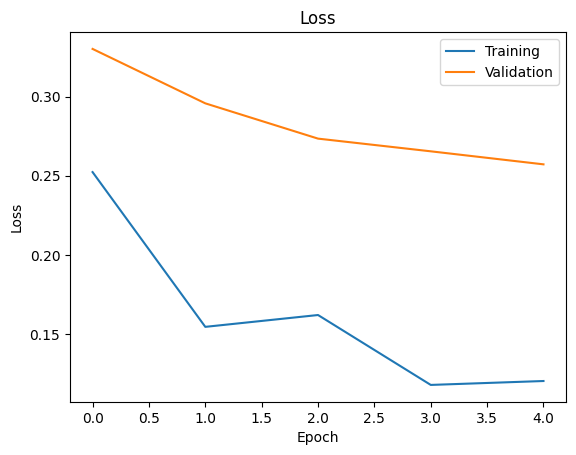

In [ ]:
# Plot the loss on the training and validation sets
plt.figure()
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(losses)
plt.plot(v_losses)
plt.legend(["Training", "Validation"], loc="upper right")
plt.show()

In [ ]:
# Save the model for future use
torch.save(model, "model.pt")

## Analysis (Keller feel free to move this elsewhere/remove. Do what ya gotta do)

In [ ]:
# Make predictions
X_test = X_test.to(device)
with torch.no_grad():
    # Run the model on the test data and transfer the result to CPU
    Y_pred = model(X_test).to("cpu")

In [ ]:
# Calculate the accuracy
accuracy = (Y_pred.round() == Y_test).float().mean()
print(f"Accuracy {accuracy}")

Accuracy 0.9014894962310791


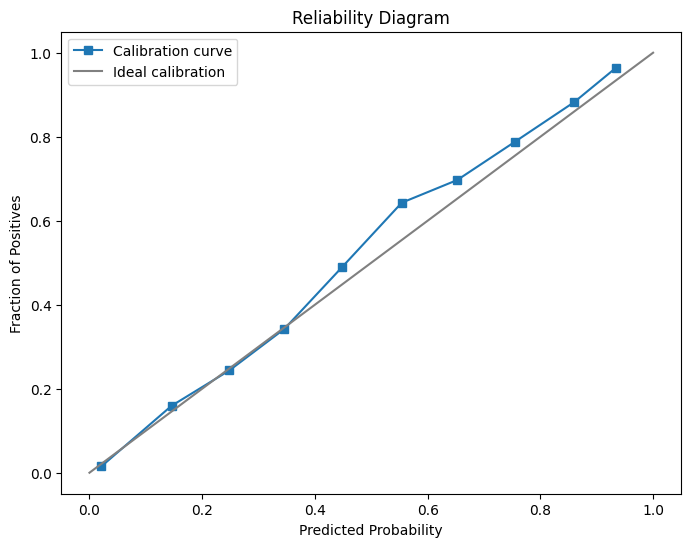

In [ ]:
# Plot the reliability diagram
prob_true, prob_pred = calibration_curve(np.array(Y_test), np.array(Y_pred)[:, 0], n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, 's-', label='Calibration curve')
plt.plot([0, 1], [0, 1], color='gray', label='Ideal calibration')
plt.xlabel('Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Reliability Diagram')
plt.legend()
plt.show()